In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
from rBergomi import rBergomi
import numpy as np
import matplotlib.pyplot as plt

In [137]:
model1 = rBergomi(nsteps = 100, npaths = 10000, T = 1.0, H = 0.1, eta=1, rho=-0.9, alpha=-0.43, hybrid=False)

In [138]:
idx = model1.t
v, u = np.zeros(pow(model1.s,2)), np.zeros(pow(model1.s,2))

k = 0
for i in product(idx, idx):
    v[k], u[k] = i
    k = k + 1

In [139]:
v

array([0., 0., 0., ..., 1., 1., 1.])

In [130]:
model1.joint_cov().shape

(200, 200)

In [125]:
Y1.shape

(100, 10000)

In [128]:
vY2.shape

(100, 1)

In [126]:
vY1 = model1.t_hybrid**(2*model1.alpha + 1) # Known variance
vY2 = np.var(Y1, axis=1, keepdims=True) # Observed variance

In [119]:
vY2

array([[0.03312775],
       [0.03807187],
       [0.04140109],
       [0.04419802],
       [0.04551142],
       [0.04770697],
       [0.04909136],
       [0.0505499 ],
       [0.0517644 ],
       [0.05258123],
       [0.05397628],
       [0.05418241],
       [0.05489748],
       [0.05635308],
       [0.05690466],
       [0.05769025],
       [0.05634295],
       [0.05979562],
       [0.05952396],
       [0.06079205],
       [0.06041085],
       [0.06115538],
       [0.06232396],
       [0.06266961],
       [0.06342313],
       [0.06355712],
       [0.06496593],
       [0.06400596],
       [0.06516269],
       [0.06486012],
       [0.06589645],
       [0.06638013],
       [0.06691962],
       [0.06743403],
       [0.06729715],
       [0.068589  ],
       [0.06869638],
       [0.0683667 ],
       [0.06894556],
       [0.06938708],
       [0.07128905],
       [0.07089402],
       [0.071424  ],
       [0.07197818],
       [0.07192122],
       [0.07270054],
       [0.072004  ],
       [0.073

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

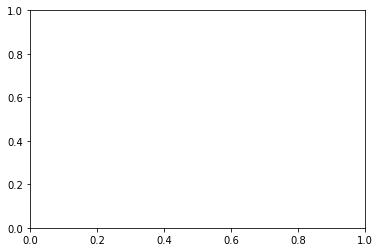

In [117]:
plot, axes = plt.subplots()
axes.plot(model1.t[0,:], vY1[0,:], 'g')
axes.plot(model1.t[0,:], vY2[0,:], 'r')
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$Y^\alpha_t$', fontsize=16)
plt.grid(True)

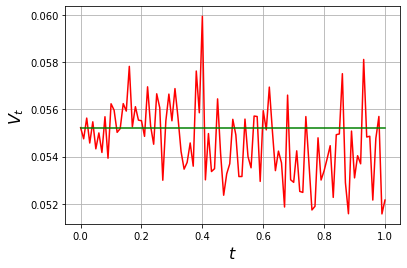

In [26]:
plot, axes = plt.subplots()
axes.plot(model1.t_hybrid[0,:], np.mean(V1, axis = 0), 'r')
axes.plot(model1.t_hybrid[0,:], 0.235**2 * np.ones_like(model1.t_hybrid)[0,:], 'g')  
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$V_t$', fontsize=16)
plt.grid(True)

In [27]:
from itertools import product
import scipy.special

def WZ(n, H, rho):
    idx = np.linspace(1,n,n)
    v, u = np.zeros(pow(n,2)), np.zeros(pow(n,2))

    k = 0
    for i in product(idx, idx):
        v[k], u[k] = i
        k = k + 1

    D = np.sqrt(2.0*H)/(H+0.5)
    res = rho * D * (v**(H+0.5)-(v-np.minimum(u,v))**(H+0.5))
    return np.reshape(res, (n,n))

def G(x, H):
    gamma = 0.5 - H
    F = scipy.special.hyp2f1(1.0,gamma,2.0-gamma,1.0/x)
    return (1.0-2.0*gamma)/(1.0-gamma)*x**(-gamma)*F

def WW(n, H):
    cov = np.zeros((n,n))

    for i in range(n):
        v = i + 1
        for j in range(n):
            u = j + 1
            if i == j:
                cov[i,j] = u**(2.0*H)
            if i > j:
                x = v/u
                cov[i,j] = u**(2.0*H)*G(x,H)
            if i < j:
                cov[i,j] = 0

    return cov + cov.T - np.diag(cov.diagonal())

def ZZ(n):
    cov = np.zeros((n,n))

    for i in range(n):
        v = i + 1
        for j in range(n):
            u = j + 1
            cov[i,j] = np.min([v,u])
    return cov

def check_symmetric(a):
    return np.allclose(a, a.T)

def joint_cov(n,H,rho):
    res = np.block([[WW(n,H), WZ(n,H,rho)],[WZ(n,H,rho).T, ZZ(n)]])
    if check_symmetric(res):
        return res
    else:
        print('Covariance matrix is not symmetric...')
    

def rB_jcov(n, H, rho):
    normal = np.random.normal(size=n*2)
    cov = joint_cov(n,H,rho)
    sigma = np.transpose(scipy.linalg.cholesky(cov))
    control = np.all(np.matmul(sigma,np.transpose(sigma)) - cov < 1e-06)
    if control:
        print("Good news, everyone! I think I perfected a scheme that will simulate all paths!")
        return sigma.dot(normal)
    else: 
        print("Bad news, everyone! I don't think the simulation is going to make it...")